In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [87]:
traindata=pd.read_pickle("./training.pkl")
testdata1=pd.read_pickle("./testing1.pkl")
testdata2=pd.read_pickle("./testing2.pkl")

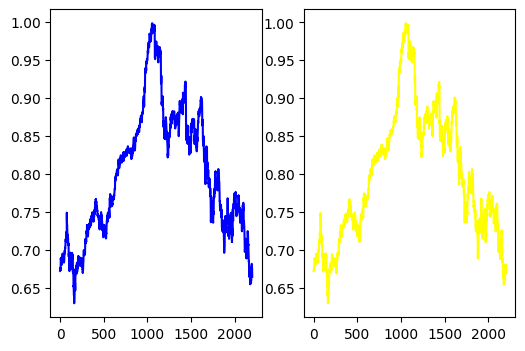

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].plot(traindata[0]['Close'],c='blue')
ax[1].plot(traindata[0]['Open'],c='yellow')

In [89]:
df = pd.DataFrame(columns=traindata[0].columns)
dftest = pd.DataFrame(columns=traindata[0].columns)
splt_pct=0.8
splt=int(len(traindata[0])*splt_pct)
for i in range(10):
    dat=traindata[i]
    df = pd.concat((df, dat.iloc[:splt,:]))
    dftest=pd.concat((dftest, dat.iloc[splt:,:]))

In [90]:
df=df['Close']
dftest=dftest['Close']

In [91]:
df=np.array(df)
dftest=np.array(dftest)

In [92]:
class dataset(Dataset):
    def __init__(self, data, lookback,splt):
        self.l= splt
        self.stocks=int(len(data)/self.l)
        self.data = data
        self.lookback = lookback
        
        
    def __len__(self):
        return (self.stocks*self.l)-(self.stocks * self.lookback )- 1

    
    def __getitem__(self, idx):
        if idx%self.l>=self.l - self.lookback:
            idx=idx+self.lookback
        
        x,y = self.data[idx : idx+lookback].reshape(-1,1), self.data[idx+1 : idx+lookback+1].reshape(-1,1)
        x = torch.as_tensor(x).float()
        y = torch.as_tensor(y).float()
        return x, y

In [1]:
lookback =60
batch_size = 40
num_layers = 2
input_dim = 1
hidden_dim = 128
output_dim = 1
dropout=0.2
learning_rate = 0.001
train_set = dataset(df, lookback,splt)

NameError: name 'dataset' is not defined

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [2]:
class LSTM(nn.Module):
    def __init__(self,input_dim, output_dim, hidden_dim, num_layers,lb):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
       

    def forward(self,x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        x = self.fc1(x)
        #x = self.relu(x)

        # LSTM layer
        out1, _ = self.lstm(x)
        out1 = self.dropout(out1)
        out2, _ = self.lstm(out1)
        out2 = self.dropout(out2)
        out3, _ = self.lstm(out2)
        # layer 2
        x = self.dropout(out3)
        output = self.fc2(x)
        
        return output

NameError: name 'nn' is not defined

In [96]:
model = LSTM(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers, lb=lookback)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [97]:
epochs=30

for epoch in range(epochs):
    for i, d in enumerate(train_loader):
        optimizer.zero_grad()
        x, t = d
        pred = model(x)
        loss = loss_func(t, pred)
        loss.backward()
        optimizer.step()

In [99]:
stock=1
predictions,y= train_set[(stock*splt)-lookback-1]
predictions=(predictions).numpy()
predictions=predictions.tolist()

In [100]:
for i in range(200):
    inp=torch.as_tensor(predictions[-lookback:],dtype=torch.float32)
    out=model(inp)
    #print(out.tolist()[-1]))
    predictions.append(out.tolist()[-1])
    


In [101]:
p=traindata[stock-1]
p=p.iloc[splt:,3]
k=np.append(df[:splt],np.array(predictions))

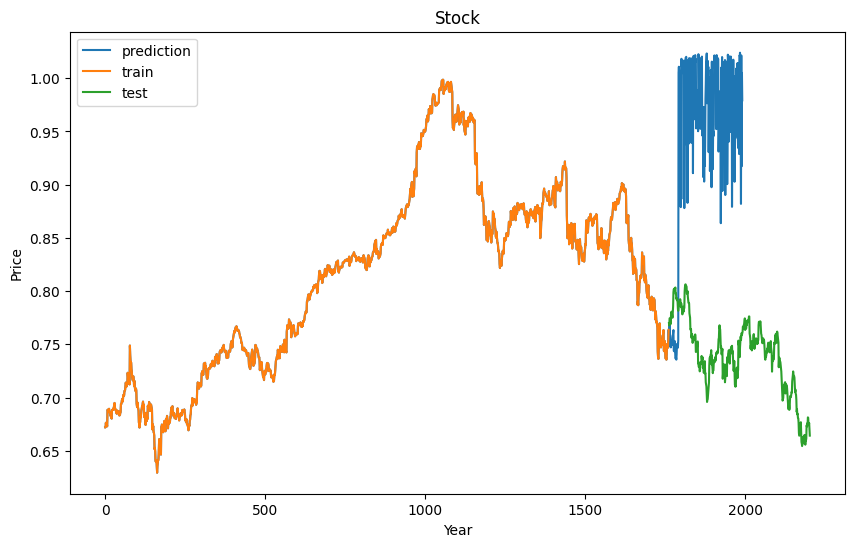

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(k, label='prediction')
ax.plot(df[:splt], label='train')
ax.plot(p,label='test')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(target, label= "Target", c='y')
ax.plot(p, label='preds')
ax.plot(train_data, label='train')
plt.xlim(2000,2200)
plt.ylim(0.65)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock2')
plt.legend()
plt.show()